In [15]:
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('lines', linewidth=4)
rc('text', usetex=True)

import cmasher as cmr

In [16]:
INPUT_DIR = OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/lm-watermarking-dev/figure_notebooks"
figure_dir = f"{INPUT_DIR}/figures"

# save = False
save = True

In [17]:
# enumerate data dir and load all csv files into a dataframe
def get_data_df(data_dir=None, data_path=None):

    data_df = pd.DataFrame()
    if data_path is None:
        for file in sorted(os.listdir(data_dir)):
            if file.endswith(".csv"):
                file_path = os.path.join(data_dir, file)
                data = pd.read_csv(file_path)
                data_df = data_df.append(data)
    else:
        data_df = pd.read_csv(data_path)

    return data_df

In [18]:

def plot_grouped_series_data(data_df, x_col="idx_T", y_col="avg", y_err_df=None, y_err_col=None, legend_loc=None, y_err_join_idx=None, x_name=None,y_name=None, series_id_col="id", series_readable_id_col="name", series_readable_id_map=None, special_color_map=None, legend_rhs=None, title="Figure Title", grid=True, save_path=None, show=True):

    # get unique series ids
    series_ids = data_df[series_id_col].unique()
    series_readable_ids = data_df[series_readable_id_col].unique()

    # check that can make a 1-1 mapping, i.e. the human readble names are unique and map to 1 series id
    assert len(series_readable_ids) == len(series_ids), "series_readable_ids is not a 1-1 mapping"
    print(series_readable_ids)

    # make human-readable series ids mapping
    series_readable_ids = data_df[[series_id_col, series_readable_id_col]].drop_duplicates().set_index(series_id_col).to_dict()[series_readable_id_col]

    if isinstance(series_readable_id_map, dict):
        series_readable_ids = {k:series_readable_id_map[v] for k,v in series_readable_ids.items()}
        print("Used dict tom map series_readable_ids")
    elif isinstance(series_readable_id_map, Callable):
        print(series_readable_ids.items())
        series_readable_ids = {k:series_readable_id_map(v) for k,v in series_readable_ids.items()}
        print("Used callable to map series_readable_ids")
    print(series_readable_ids)


    # if isinstance(series_readable_id_map, dict):
    #     series_readable_ids = {k: series_readable_id_map[k] for k in series_readable_id_map.keys()}
    # elif isinstance(series_readable_id_map, Callable):
    #     series_readable_ids = {series_readable_id_map(k): series_readable_ids[k]  for k in series_readable_ids[series_readable_id_col]}
    #     print("Used callable to map series_readable_ids")
    #     print(series_readable_ids)

    # set up figure
    fig, ax = plt.subplots(figsize=(10, 6))


    ####################################
    # Custom sorting and droping stuff

    # sort the groups by the largest y_col value, avg etc.
    # sorted_series_ids = data_df.groupby(series_id_col)[y_col].max().sort_values(ascending=False).index
    # sorted_series_ids = data_df[data_df[x_col] == 1000].groupby(series_id_col)[y_col].max().sort_values(ascending=False).index
    
    # sort by avg y_col value and drop series that don't have an x_col value of 500
    # sorted_series_ids = data_df[data_df[x_col] == 500].groupby(series_id_col)[y_col].mean().sort_values(ascending=False).index
    # nvrmnd, just sort by avg y_col value
    sorted_series_ids = data_df.groupby(series_id_col)[y_col].mean().sort_values(ascending=False).index

    print([series_readable_ids[i] for i in sorted_series_ids])
    print(f"droping {len(series_ids) - len(sorted_series_ids)} series")

    
    # get a randomly dispersed colormap from cmr for these series
    # So that we can tell them apart
    cmap = cmr.take_cmap_colors("cmr.rainforest", len(sorted_series_ids), cmap_range=(0.2, 0.8), return_fmt="hex")

    ####################################

    # plot each series
    for i, series_id in enumerate(sorted_series_ids):
        if special_color_map and series_readable_ids[series_id] in special_color_map.keys():
            color = special_color_map[series_readable_ids[series_id]]
        else:
            color = cmap[i]

        series_df = data_df[data_df[series_id_col] == series_id]
        # ax.plot(series_df[x_col], series_df[y_col], label=series_readable_ids[series_id], color=COLORS[series_id], alpha=0.8)
        # ax.plot(series_df[x_col], series_df[y_col], label=series_readable_ids[series_id])

        # add std error bars if the col exists
        # ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=0.8)
        if y_err_df is not None:
            #  plot the stderr col in the df matching it to the x_col in the series_df
            # get the error series that corresponds to the idx col values in the series_df
            y_err_subdf = y_err_df[y_err_df[series_id_col] == series_id]
            err_series = y_err_subdf[y_err_col]
            # err_series = y_err_subdf[y_err_subdf[y_err_join_idx].isin(y_err_subdf[y_err_join_idx])][y_err_col]
            ax.errorbar(series_df[x_col], series_df[y_col], yerr=err_series, label=series_readable_ids[series_id], color=color, alpha=0.1)
            
        if series_readable_ids[series_id] == "Human Avg":
            ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=0.8, zorder=5)
        else:
            ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=0.8)

    # set up legend, but exclude stderr if it's there
    handles, labels = ax.get_legend_handles_labels()
    print(handles)
    print(labels)
    if y_err_df is not None:
        # assume they're the first half
        handles = handles[:len(handles)//2]
        labels = labels[:len(labels)//2]

    if legend_rhs is not None:
        ax.legend(handles, labels,loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    else:    
        ax.legend(handles, labels,loc=legend_loc, fontsize=12)
    
    # set up title
    ax.set_title(title)
    # label axes
    ax.set_xlabel(x_name if x_name else x_col)
    ax.set_ylabel(y_name if y_name else y_col)

    # turn on grid
    ax.grid(grid)

    # tight
    fig.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")
    
    # show figure
    if show:
        plt.show()


In [19]:
fig_name = "human_clean_z_at_T"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,avg,id,idx_T,name
0,12,1.021466,l2nl3pg4,0,user_all_eval
1,12,1.067726,l2nl3pg4,1,user_all_eval
2,12,0.948718,l2nl3pg4,2,user_all_eval
3,12,1.154701,l2nl3pg4,3,user_all_eval
4,12,1.251271,l2nl3pg4,4,user_all_eval
...,...,...,...,...,...
21065,14,24.296869,71qr1vhn,1178,user_21_eval
21066,14,24.269766,71qr1vhn,1179,user_21_eval
21067,14,24.309887,71qr1vhn,1180,user_21_eval
21068,14,24.282808,71qr1vhn,1181,user_21_eval


['user_all_eval' 'user_12_eval' 'user_17_eval' 'user_19_eval'
 'user_18_eval' 'user_16_eval' 'user_10_eval' 'user_22_eval' 'user_7_eval'
 'user_3_eval' 'user_15_eval' 'user_24_eval' 'user_13_eval' 'user_11_eval'
 'user_21_eval']
dict_items([('l2nl3pg4', 'user_all_eval'), ('043jwr3j', 'user_12_eval'), ('260gyudz', 'user_17_eval'), ('2to75l83', 'user_19_eval'), ('l7v88zn5', 'user_18_eval'), ('mok6demm', 'user_16_eval'), ('o95l8xtj', 'user_10_eval'), ('6p9426oe', 'user_22_eval'), ('99085874', 'user_7_eval'), ('g7729nt5', 'user_3_eval'), ('75uimguq', 'user_15_eval'), ('frx0ovrn', 'user_24_eval'), ('m1qrluzf', 'user_13_eval'), ('y4rnvzwa', 'user_11_eval'), ('71qr1vhn', 'user_21_eval')])
Used callable to map series_readable_ids
{'l2nl3pg4': 'Human Avg', '043jwr3j': 'Human 12', '260gyudz': 'Human 17', '2to75l83': 'Human 19', 'l7v88zn5': 'Human 18', 'mok6demm': 'Human 16', 'o95l8xtj': 'Human 10', '6p9426oe': 'Human 22', '99085874': 'Human 7', 'g7729nt5': 'Human 3', '75uimguq': 'Human 15', 'frx

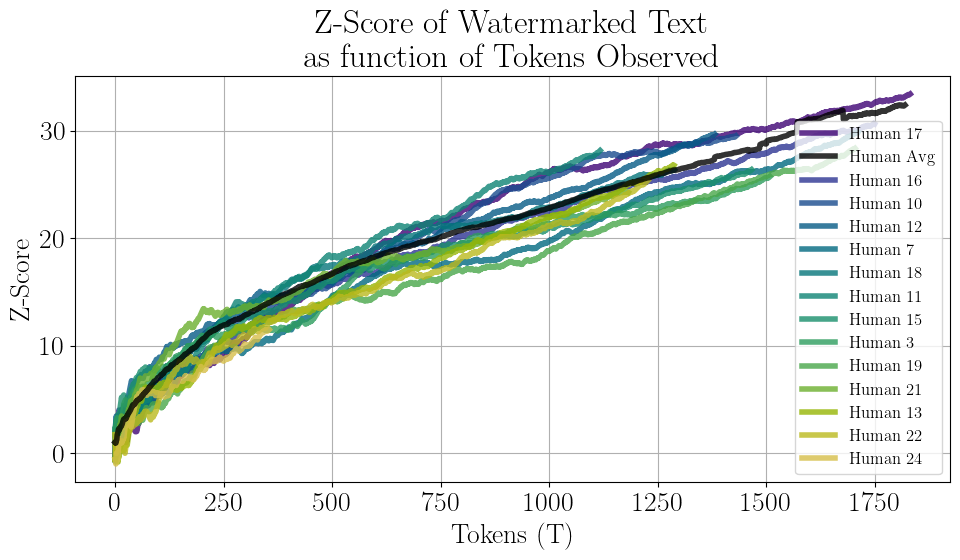

In [20]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="avg",
    x_name="Tokens (T)",
    y_name="Z-Score",
    series_id_col="id",
    legend_loc="lower right",
    series_readable_id_col="name",
    series_readable_id_map=lambda x: x.replace("user_", "Human ").replace("_eval", "").replace("all","Avg"),
    special_color_map={"Human Avg":"black"},
    title=f"Z-Score of Watermarked Text\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [21]:
fig_name = "human_attacked_z_at_T"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,avg,id,idx_T,name
0,12,0.133235,l2nl3pg4,0,user_all_eval
1,12,-0.062807,l2nl3pg4,1,user_all_eval
2,12,-0.076923,l2nl3pg4,2,user_all_eval
3,12,0.088823,l2nl3pg4,3,user_all_eval
4,12,0.139030,l2nl3pg4,4,user_all_eval
...,...,...,...,...,...
16978,14,4.519708,71qr1vhn,1171,user_21_eval
16979,14,4.500924,71qr1vhn,1172,user_21_eval
16980,14,4.482156,71qr1vhn,1173,user_21_eval
16981,14,4.530777,71qr1vhn,1174,user_21_eval


['user_all_eval' 'user_12_eval' 'user_17_eval' 'user_19_eval'
 'user_18_eval' 'user_16_eval' 'user_10_eval' 'user_22_eval' 'user_7_eval'
 'user_3_eval' 'user_15_eval' 'user_24_eval' 'user_13_eval' 'user_11_eval'
 'user_21_eval']
dict_items([('l2nl3pg4', 'user_all_eval'), ('043jwr3j', 'user_12_eval'), ('260gyudz', 'user_17_eval'), ('2to75l83', 'user_19_eval'), ('l7v88zn5', 'user_18_eval'), ('mok6demm', 'user_16_eval'), ('o95l8xtj', 'user_10_eval'), ('6p9426oe', 'user_22_eval'), ('99085874', 'user_7_eval'), ('g7729nt5', 'user_3_eval'), ('75uimguq', 'user_15_eval'), ('frx0ovrn', 'user_24_eval'), ('m1qrluzf', 'user_13_eval'), ('y4rnvzwa', 'user_11_eval'), ('71qr1vhn', 'user_21_eval')])
Used callable to map series_readable_ids
{'l2nl3pg4': 'Human Avg', '043jwr3j': 'Human 12', '260gyudz': 'Human 17', '2to75l83': 'Human 19', 'l7v88zn5': 'Human 18', 'mok6demm': 'Human 16', 'o95l8xtj': 'Human 10', '6p9426oe': 'Human 22', '99085874': 'Human 7', 'g7729nt5': 'Human 3', '75uimguq': 'Human 15', 'frx

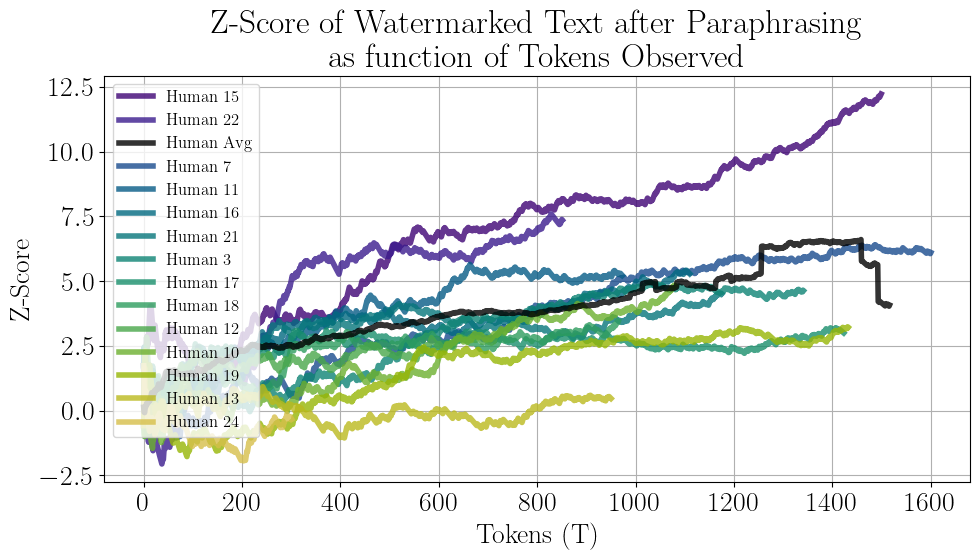

In [22]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="avg",
    x_name="Tokens (T)",
    y_name="Z-Score",
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=lambda x: x.replace("user_", "Human ").replace("_eval", "").replace("all","Avg"),
    special_color_map={"Human Avg":"black"},
    legend_loc="upper left",
    title=f"Z-Score of Watermarked Text after Paraphrasing\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [23]:
def plot_scatter_data(data_df, x_col="x", y_col="y",x_name=None,y_name=None, series_readable_id_col="name", series_readable_id_map=None, special_color_map=None, title="Figure Title", marker_size=10, grid=True, save_path=None, show=True):
    
    # give each point a unique marker and color
    # make a random colormap
    cmap = cmr.take_cmap_colors("cmr.rainforest", len(data_df), cmap_range=(0.2, 0.8), return_fmt="hex")
    # markers = ["o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
    markers = ["o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_", "o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]


    #plot using plt.scatter
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, row in data_df.iterrows():

        if special_color_map and row[series_readable_id_col] in special_color_map.keys():
            color = special_color_map[row[series_readable_id_col]]
        else:
            color = cmap[i]
        if isinstance(series_readable_id_map, dict):
            label = series_readable_id_map[row[series_readable_id_col]]
        elif isinstance(series_readable_id_map, Callable):
            label = series_readable_id_map(row[series_readable_id_col])

        ax.scatter(row[x_col], row[y_col], label=label, color=color, marker=markers[i], alpha=0.8, sizes=[marker_size])
    
    # sort legend the value of x_col for each id
    handles, labels = ax.get_legend_handles_labels()
    x_vals = data_df[x_col]
    # sort by x_vals
    handles, labels, _ = zip(*sorted(zip(handles, labels, x_vals), key=lambda t: t[2], reverse=True))
    ax.legend(handles, labels,loc="lower right", fontsize=12)
    
    # set title
    plt.title(title)
    # label axes
    plt.xlabel(x_name if x_name else x_col)
    plt.ylabel(y_name if y_name else y_col)

    # turn on grid
    ax.grid(grid)

    # tight
    plt.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")

    # show figure
    if show:
        plt.show()



In [24]:
fig_name = "human_z_psp_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,Name,w_wm_output_attacked_z_score.mean,w_wm_output_vs_w_wm_output_attacked_p_sp.mean,_wandb
0,user_all_eval,4.853425,0.925806,NaN
1,user_12_eval,3.345330,0.869875,NaN
2,user_17_eval,2.998751,0.917081,NaN
3,user_19_eval,3.218094,0.929195,NaN
4,user_18_eval,3.455125,0.919629,NaN
5,user_16_eval,5.283019,0.888357,NaN
6,user_10_eval,4.829022,0.899860,NaN
7,user_22_eval,7.358046,0.942407,NaN
8,user_7_eval,6.103572,0.960798,NaN
9,user_3_eval,4.633514,0.929342,NaN


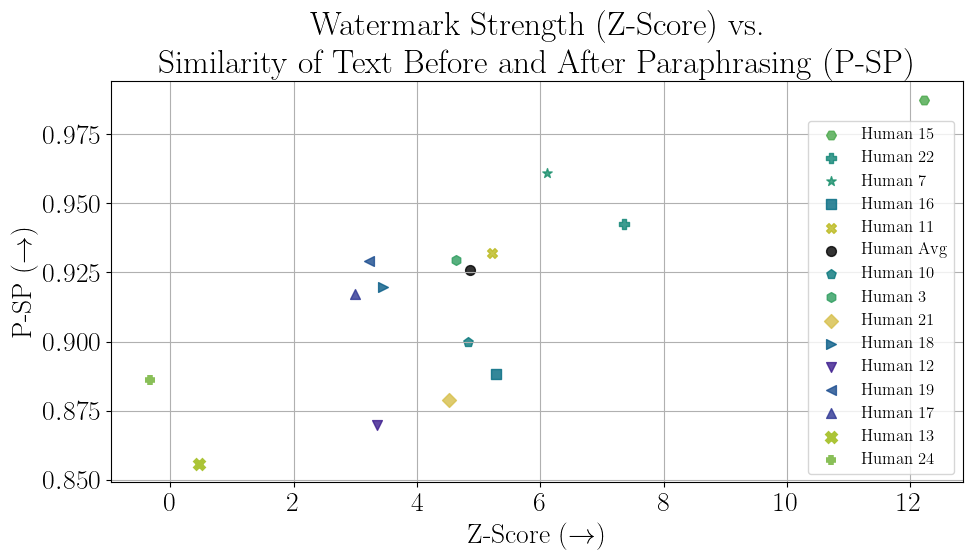

In [25]:
plot_scatter_data(
    data_df=df,
    x_col="w_wm_output_attacked_z_score.mean",
    y_col="w_wm_output_vs_w_wm_output_attacked_p_sp.mean",
    x_name=r"Z-Score $(\rightarrow)$",
    y_name=r"P-SP $(\rightarrow)$",
    marker_size=50,
    series_readable_id_col="Name",
    series_readable_id_map=lambda x: x.replace("user_", "Human ").replace("_eval", "").replace("all","Avg"),
    special_color_map={"user_all_eval":"black"},
    title="Watermark Strength (Z-Score) vs.\nSimilarity of Text Before and After Paraphrasing (P-SP)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [26]:
fig_name = "human_avg_and_machine_attack_at_T"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_path=f"{data_dir}/avg.csv")
df

,_defaultColorIndex,avg,id,idx_T,name
0,14,0.488527,hoacxsvt,0,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...
1,14,0.062807,hoacxsvt,1,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...
2,14,0.128205,hoacxsvt,2,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...
3,14,0.266469,hoacxsvt,3,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...
4,14,0.536259,hoacxsvt,4,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...
...,...,...,...,...,...
4268,15,8.489768,oqkrcdb9,1264,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...
4269,15,8.470187,oqkrcdb9,1265,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...
4270,15,8.450624,oqkrcdb9,1266,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...
4271,15,8.495932,oqkrcdb9,1267,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...


In [27]:
std_err_df = get_data_df(data_path=f"{data_dir}/stderr.csv")
std_err_df

,_defaultColorIndex,id,idx_T,name,stderr
0,14,hoacxsvt,0,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...,0.306196
1,14,hoacxsvt,1,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...,0.216535
2,14,hoacxsvt,2,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...,0.234349
3,14,hoacxsvt,3,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...,0.172366
4,14,hoacxsvt,4,vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filt...,0.179909
...,...,...,...,...,...
4268,15,oqkrcdb9,1264,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...,NaN
4269,15,oqkrcdb9,1265,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...,NaN
4270,15,oqkrcdb9,1266,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...,NaN
4271,15,oqkrcdb9,1267,vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filter...,NaN


['vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filtered_eval'
 'vicuna_lfqa_600_0-25_4-0_0-7_1-0_dipper_high_filtered_eval'
 'vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filtered_eval']
Used dict tom map series_readable_ids
{'hoacxsvt': 'Average Human', 'i3xytq1d': 'Dipper', 'oqkrcdb9': 'GPT'}
['Dipper', 'GPT', 'Average Human']
droping 0 series
[<matplotlib.lines.Line2D object at 0x7faa754cf2b0>, <matplotlib.lines.Line2D object at 0x7faa75112a40>, <matplotlib.lines.Line2D object at 0x7faa74f63bb0>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>]
['Dipper', 'GPT', 'Average Human', 'Dipper', 'GPT', 'Average Human']


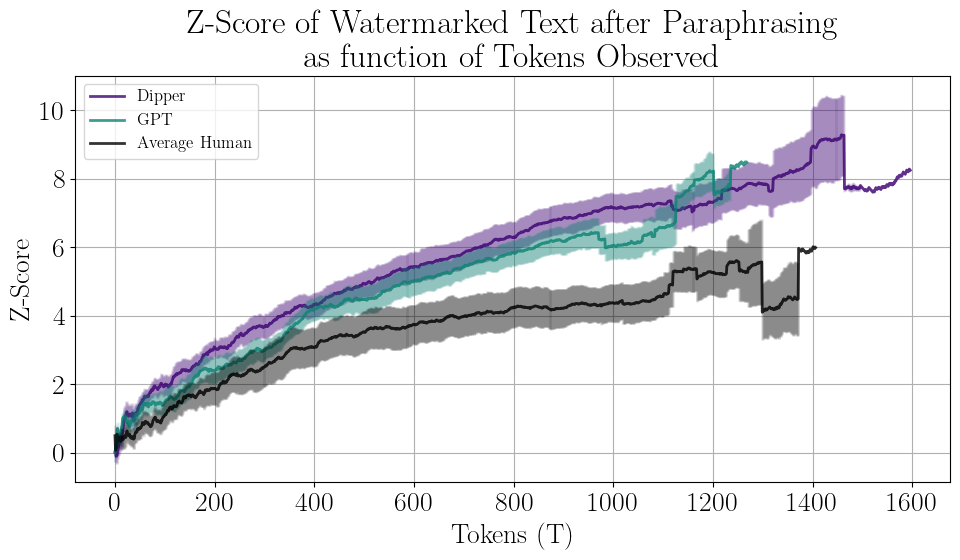

In [28]:
name_map = {
    "vicuna_lfqa_600_0-25_4-0_0-7_1-0_user_all_filtered_eval": "Average Human",
    'vicuna_lfqa_600_0-25_4-0_0-7_1-0_dipper_high_filtered_eval': "Dipper",
    'vicuna_lfqa_600_0-25_4-0_0-7_1-0_gpt_p4_filtered_eval': "GPT",
}
rc('lines', linewidth=2)
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="avg",
    y_err_df=std_err_df,
    y_err_col="stderr",
    y_err_join_idx="idx_T",
    x_name="Tokens (T)",
    y_name="Z-Score",
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map = name_map,
    special_color_map={"Average Human":"black"},
    title=f"Z-Score of Watermarked Text after Paraphrasing\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)